<a href="https://colab.research.google.com/github/astrfo/RS_init/blob/main/RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RS 実装

[満足化を通じた最適な自律的探索] https://www.jstage.jst.go.jp/article/pjsai/JSAI2018/0/JSAI2018_1Z304/_article/-char/ja/

[論文要約] https://github.com/astrfo/AutonomousOptimalExplorationThroughSatisficing/blob/main/AutonomousOptimalExplorationThroughSatisficing.ipynb




In [28]:
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
class Environment(object):
    """
    K本の各腕の確率を生成
    当たりかハズレかを返す
    """

    def __init__(self, K):
        self._K = K
        self.prob = np.array([np.random.rand() for _ in range(K)])
        # print(f'prob: {self.prob}')

    def play(self, arm):
        if self.prob[arm] > np.random.rand():
            return 1
        else:
            return 0

In [30]:
class Policy(object):
    """
    各方策の実行
    """

    def __init__(self, policy):
        if 'RS' == policy:
            self.act_policy = self.rsFunc
        if 'e_greedy' == policy:
            self._epsilon = 0.5
            self.act_policy = self.e_greedy
        if 'random' == policy:
            self.act_policy = self.random_


    def rsFunc(self, _, RS):        #直せ
        return np.argmax(RS)

    def e_greedy(self, V, _):
        if self._epsilon < np.random.rand():
            return np.random.choice(np.where(V == V.max())[0])
        else:
            return np.random.randint(len(V))

    def random_(self, V, _):
        return np.random.randint(len(V))

In [31]:
class RSAgent(object):
    """
    経験期待値の更新
    RS価値関数の定義、更新
    # 基準値alephの更新
    RS-greedy選択肢を試行する
    """

    def __init__(self, K, policy):
        self._K = K
        self._alpha = None
        self._V = None
        self._n = None
        self._N = None
        self.RS = None
        self.aleph = None
        self._mu = None
        self._D = None
        self._policy = Policy(policy)

    def initialize(self):
        self._V = np.array([0.5] * self._K)
        self._n = np.array([1e-8] * self._K)
        self._N = 0
        self.RS = np.zeros(self._K)
        self.aleph = 1.2
        self._mu = 0.0
        self._D = 0.0

    def update(self, arm, reward):
        self._alpha = 1 / (1 + self._n[arm])
        self._V[arm] = (1 - self._alpha) * self._V[arm] + (reward * self._alpha)
        self._n[arm] += 1
        self._N += 1
        self.RS[arm] = (self._n[arm] / self._N) * (self._V[arm] - self.aleph)
        # print(f'V: {self._V}')
        # G = random.choice(np.where(self._V == self._V.max())[0])
        # j = 0 if G == 1 else 1
        # self.D_KL(self._V[j], self._V[G])

    def update_aleph(self):
        G = random.choice(np.where(self._V == self._V.max())[0])
        j = 0 if G == 1 else 1
        self._mu = np.exp(-self._n[j] * self._D)
        self.aleph = self._V[G] * (1 - (self._V[j]/self._V[G]) * self._mu) / (1 - self._mu)

    def D_KL(self, p, q):
        self._D += (p * np.log(p/q))

    def select_arm(self):
        return self._policy.act_policy(self._V, self.RS)

    def calc_z(self):
        return 1 / np.sum(1 / (self.aleph - self._V))

In [32]:
class Simulator(object):
    """
    シミュレーションを行う
    regretの計算
    regret,stepsをplot
    """
    
    def __init__(self, trial, step, K):
        self._algorithm = ["random", "RS",  "e_greedy"]
        self._env = None
        self._prob = None
        self._trial = trial
        self._step = step
        self._K = K
        self._regret = np.zeros((trial, step))
        self.fig, self.ax = plt.subplots()

    def run(self):
        for algo in self._algorithm:
            self._agent = RSAgent(self._K, algo)
            print(f'algorithm: {algo}')
            for t in range(self._trial):
                self._env = Environment(self._K)
                self._prob = self._env.prob
                self._agent.initialize()
                for s in range(self._step):
                    arm = self._agent.select_arm()
                    reward = self._env.play(arm)
                    self._agent.update(arm, reward)
                    self.calc_regret(t, s, arm)
                # self._agent.update_aleph()
            self.print_regret()
        self.fig.tight_layout()
        plt.show()

    def calc_regret(self, t, s, arm):
        self._regret[t][s] = (self._prob.max() - self._prob[arm])
        if s != 0: self._regret[t][s] += self._regret[t][s-1]

    def print_regret(self):
        self.ax.plot(np.arange(self._step), np.mean(self._regret, axis=0), linestyle='dashed')
        self.ax.set_xlabel("steps")
        self.ax.set_ylabel("regret")
        self.ax.legend(labels=self._algorithm)

algorithm: random
algorithm: RS
algorithm: e_greedy


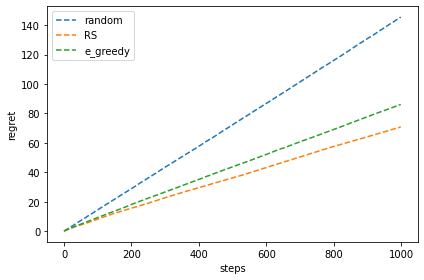

In [33]:
def main():
    trial = 100
    step = 1000
    K = 2
    sim = Simulator(trial, step, K)
    sim.run()

main()

In [34]:
# def update_aleph(self):
#         #2本腕を想定
#         G = random.choice(np.where(self._V == self._V.max())[0])
#         if G == 0: j = 1     #G:(maxIndex), j:(NotMaxIndex)
#         else: j = 0
#         mu = self._n[j]/self._n[G]
#         #step数が小さいと upper = lower になる可能性がある
#         #腕の確率が小さいと V(a_G) = V(a_j) = 0 でエラーになる可能性がある(一度も当たらない(かなりレアケース))
#         self.aleph = self._V.max() * (1 - (self._V[j]/self._V[G]) * mu) / 1 - mu